# 1. Path Setting + Import Library

In [1]:
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import os
import numpy as np 
# === 1) home path(where the data is stored)
BASE_DIR = Path().resolve().parent
BASE_PATH = BASE_DIR / 'data' / 'monarq_data'

# === 2) target coins
# SPOT_SYMBOLS = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "SOLUSDT", "DOGEUSDT"]
SPOT_SYMBOLS = ["BTCUSDT", "ETHUSDT"]

ALL_SYMBOLS = SPOT_SYMBOLS

# === 3) data types list
CORE_DATA_TYPES = ["trade_1min", "level1_1min", "book_1min", "openinterest_1min"]

# optional: if we can get liquidation data later it's ok to add it.
INCLUDE_LIQUIDATION = False   # no data

if INCLUDE_LIQUIDATION:
    DATA_TYPES = CORE_DATA_TYPES + ["liquidation_1min"]
else:
    DATA_TYPES = CORE_DATA_TYPES

TYPE_PREFIX = {
    "trade_1min": "tr",   # trade
    "level1_1min": "l1",  # L1 order book
    "book_1min":   "l2",  # L2 order book
    "openinterest_1min": "oi",  # open interest
    "liquidation_1min": "liq",  # no data but with integral structure
}

print(ALL_SYMBOLS, DATA_TYPES)

['BTCUSDT', 'ETHUSDT'] ['trade_1min', 'level1_1min', 'book_1min', 'openinterest_1min']


# 2. Data Load + Preprocessing

In [3]:
def load_one_type_symbol(base_path: Path, data_type: str, symbol: str, prefix: str):
    """
    Read all 1-minute files for a given symbol (e.g., 'BTCUSDT') under a given data_type (e.g., 'trade_1min').

    Perform basic cleaning and prefix the columns.

    - If the directory does not exist/there are no files, return None and print a [WARN].

    - ts_end: Treats as millisecond-level timestamps → converts to UTC datetime and sets it as the index.
    """
    folder = base_path / data_type / symbol
    if not folder.exists():
        print(f"[WARN] Folder not found: {folder}")
        return None

    files = sorted(folder.glob("*.csv.gz"))
    if not files:
        print(f"[WARN] No files in {folder}")
        return None

    dfs = []
    for f in files:
        try:
            df = pd.read_csv(f)
            dfs.append(df)
        except Exception as e:
            print(f"[WARN] Failed to read {f}: {e}")

    if not dfs:
        print(f"[WARN] No valid dataframes for {data_type} / {symbol}")
        return None

    df = pd.concat(dfs, ignore_index=True)

    # Timestamp processing: Server data is ts_end in ms
    if "ts_end" not in df.columns:
        print(f"[WARN] ts_end missing in {data_type} / {symbol}, columns={df.columns.tolist()}")
        return None

    df["ts_end"] = pd.to_datetime(df["ts_end"], unit="ms", utc=True)
    df = df.sort_values("ts_end").set_index("ts_end")

    # Remove duplicate timestamps (keep the last one).
    df = df[~df.index.duplicated(keep="last")]

    # Add a prefix to all columns to avoid column name conflicts during subsequent joins.
    col_map = {col: f"{prefix}__{col}" for col in df.columns}
    df = df.rename(columns=col_map)

    return df

def build_combined_symbol_df(base_path: Path,
                             symbol: str,
                             data_types=DATA_TYPES,
                             type_prefix_map=TYPE_PREFIX):
    """
    
    For a given symbol (e.g., 'BTCUSDT'), load all specified data types,

    and perform an outer join based on the time index to obtain a complete 1-minute data table.

    - Note: openinterest_1min currently only has data for 2024;

    For the 2023 time period, the corresponding oi__* columns will naturally all be NaN → this is normal and acceptable.

    - liquidation_1min is not loaded by default because this directory is empty on the server.
    """
    dfs = []
    for dt in tqdm(data_types, desc=f"Loading {symbol}", unit="dtype"):
        prefix = type_prefix_map.get(dt, dt)
        df = load_one_type_symbol(base_path, dt, symbol, prefix)
        if df is not None and not df.empty:
            dfs.append(df)
        else:
            print(f"[INFO] Skip empty {dt} for {symbol}")

    if not dfs:
        print(f"[ERROR] No data loaded at all for {symbol}")
        return None

    combined = dfs[0]
    for df in dfs[1:]:
        # Outer join indexed by time, not mandatory to include all elements
        combined = combined.join(df, how="outer")

    # Sort by time again, just to be on the safe side.
    combined = combined.sort_index()

    return combined


## 2.1 Read the original data

In [4]:
combined_data = {}

for sym in ALL_SYMBOLS:
    print(f"\n=== Building combined df for {sym} ===")
    df = build_combined_symbol_df(BASE_PATH, sym)
    if df is not None:
        combined_data[sym] = df
        print(f"{sym}: shape = {df.shape}")
    else:
        print(f"[WARN] No combined df for {sym}")
        
symbols_keep = ["BTCUSDT", "ETHUSDT"]

combined_data_clean = {sym: combined_data[sym] for sym in symbols_keep}


=== Building combined df for BTCUSDT ===


Loading BTCUSDT:   0%|          | 0/4 [00:00<?, ?dtype/s]

BTCUSDT: shape = (1052641, 113)

=== Building combined df for ETHUSDT ===


Loading ETHUSDT:   0%|          | 0/4 [00:00<?, ?dtype/s]

ETHUSDT: shape = (1052641, 113)


## 2.2 Read the Funding Data

In [5]:
# Replace this with your own complete path
import os
import glob
base_path = str(BASE_DIR / 'data' / 'binance_rates')

symbols = ["BTCUSDT", "ETHUSDT"]


def load_symbol_rates(symbol: str, base_path: str) -> pd.DataFrame:
    """
    Read all rates_light.csv.gz for a given symbol with progress bar.
    """
    pattern = os.path.join(base_path, f"{symbol}*.rates_light.csv.gz")
    files = sorted(glob.glob(pattern))
    
    if not files:
        raise FileNotFoundError(f"No files for {symbol} with pattern: {pattern}")

    df_list = []

    print(f"\n=== Loading funding rates for {symbol} ({len(files)} files) ===")
    for f in tqdm(files, desc=f"{symbol} files", unit="file"):
        tmp = pd.read_csv(f)

        # normalize column names
        cols = {c.lower(): c for c in tmp.columns}

        # timestamp column
        if "ts" in cols:
            ts_col = cols["ts"]
        elif "timestamp" in cols:
            ts_col = cols["timestamp"]
        elif "fundingtime" in cols:
            ts_col = cols["fundingtime"]
        else:
            raise KeyError(f"Timestamp column not found in {f}")

        # rate column
        if "rate" in cols:
            rate_col = cols["rate"]
        elif "fundingrate" in cols:
            rate_col = cols["fundingrate"]
        else:
            raise KeyError(f"Rate column not found in {f}")

        tmp = tmp[[ts_col, rate_col]].copy()
        tmp.columns = ["ts", "rate"]

        tmp["ts"] = tmp["ts"].astype("int64")
        tmp["dt"] = pd.to_datetime(tmp["ts"], unit="ms", utc=True)
        tmp["symbol"] = symbol
        
        df_list.append(tmp)

    df = pd.concat(df_list, ignore_index=True)
    df = df.sort_values("dt").drop_duplicates(subset=["dt"])

    return df[["ts", "dt", "symbol", "rate"]]


# ========= 3. Read all symbols with TQDM ==========

def load_all_funding_rates(symbols, base_path):
    rates_dict = {}
    all_list = []

    print("\n=== Loading funding rates for all symbols ===")
    for sym in tqdm(symbols, desc="Symbols", unit="symbol"):
        df = load_symbol_rates(sym, base_path)
        rates_dict[sym] = df
        all_list.append(df)

    long_df = pd.concat(all_list, ignore_index=True)

    panel_df = (
        long_df.pivot(index="dt", columns="symbol", values="rate")
        .sort_index()
    )

    return rates_dict, panel_df


# ========= 4. Actual execution loading==========
rates_dict, panel_rates = load_all_funding_rates(symbols, base_path)

# 
for s in symbols:
    print(f"\n=== {s} ===")
    print(rates_dict[s].head())

print("\nPanel wide table (first 5 rows):")
print(panel_rates.head())


=== Loading funding rates for all symbols ===


Symbols:   0%|          | 0/2 [00:00<?, ?symbol/s]


=== Loading funding rates for BTCUSDT (1469 files) ===


BTCUSDT files:   0%|          | 0/1469 [00:00<?, ?file/s]


=== Loading funding rates for ETHUSDT (1464 files) ===


ETHUSDT files:   0%|          | 0/1464 [00:00<?, ?file/s]


=== BTCUSDT ===
                  ts                        dt   symbol    rate
0      1672531200000 2023-01-01 00:00:00+00:00  BTCUSDT  0.0001
15274  1672534800000 2023-01-01 01:00:00+00:00  BTCUSDT  0.0000
2      1672538400000 2023-01-01 02:00:00+00:00  BTCUSDT  0.0001
3      1672542000000 2023-01-01 03:00:00+00:00  BTCUSDT  0.0001
15277  1672545600000 2023-01-01 04:00:00+00:00  BTCUSDT  0.0000

=== ETHUSDT ===
                  ts                        dt   symbol    rate
0      1672531200000 2023-01-01 00:00:00+00:00  ETHUSDT  0.0001
15443  1672534800000 2023-01-01 01:00:00+00:00  ETHUSDT  0.0000
2      1672538400000 2023-01-01 02:00:00+00:00  ETHUSDT  0.0001
3      1672542000000 2023-01-01 03:00:00+00:00  ETHUSDT  0.0001
15446  1672545600000 2023-01-01 04:00:00+00:00  ETHUSDT  0.0000

Panel wide table (first 5 rows):
symbol                     BTCUSDT  ETHUSDT
dt                                         
2023-01-01 00:00:00+00:00   0.0001   0.0001
2023-01-01 01:00:00+00:00   0.00

# 3. Feature Extraction

## 3.1 Feature Creation

In [6]:
def rebuild_all_pdf_features(
    combined_data_clean: dict,
    base_symbol: str = "BTCUSDT"
) -> dict:
    """
    Reconstructs all necessary features (excluding sentiment) from the PDF using `combined_data_clean`.

    Assumptions:

    - The index of each data frame is `ts_end` (datetime, UTC).

    - The original microstructure columns `tr__*`, `l1__*`, `l2__*`, `oi__*`, `OFI_raw`, `rv_fwd_*`, etc., already exist.

    Parameters:

    `combined_data_clean`: {symbol -> DataFrame}

    `funding_long`: Optional; must have at least `['dt', 'symbol', 'funding_rate']`, where `dt` is the minute-based UTC value.

    `base_symbol`: The base currency for the cross-asset, defaults to 'BTCUSDT'.

    Returns:

    `combined_data_full`: {symbol -> DataFrame}, containing all features.
    """

    eps = 1e-8  # 
    combined_out = {}

    # ---------- 0. Prepare the datasheet for base_symbol for cross-asset. ----------
    if base_symbol not in combined_data_clean:
        raise KeyError(f"base_symbol '{base_symbol}' not in combined_data_clean")

    # First, process the basic fields of base_df (ret_1m, rv_30m, etc.), then use them for cross-asset processing.
    def _prepare_base_df(df_base: pd.DataFrame) -> pd.DataFrame:
        dfb = df_base.copy()

    # index -> dt, symbol
        if "dt" not in dfb.columns:
            dfb["dt"] = pd.to_datetime(dfb.index)
        if "symbol" not in dfb.columns:
            pass  # 

    # ===== Add OFI_raw logic here. =====
        if "OFI_raw" not in dfb.columns:
            if {"tr__buy_volume", "tr__sell_volume"}.issubset(dfb.columns):
                dfb["OFI_raw"] = dfb["tr__buy_volume"] - dfb["tr__sell_volume"]
            else:
                print("⚠ base df don't have buy/sell volume，can't get OFI_raw")
                dfb["OFI_raw"] = np.nan

    # ret_1m
        if "ret_1m" not in dfb.columns:
            if "tr__close_price" in dfb.columns:
                dfb["ret_1m"] = dfb["tr__close_price"].pct_change()
            else:
                print("⚠ base df don't have tr__close_price，can't get ret_1m")
                dfb["ret_1m"] = np.nan

    # rv_30m
        if "rv_30m" not in dfb.columns:
            if "ret_1m" in dfb.columns:
                dfb["rv_30m"] = (
                    dfb["ret_1m"].pow(2)
                    .rolling(window=30, min_periods=10)
                    .sum()
                )
            else:
                print("⚠ base df don't have ret_1m，can't get rv_30m")
                dfb["rv_30m"] = np.nan

        return dfb


    base_df_raw = combined_data_clean[base_symbol]
    base_df = _prepare_base_df(base_df_raw)

    # Note: The symbol name is not yet known in base_df, but since the cross-asset is only aligned by time, base_df["symbol"] will not be used later.

    # ---------- 2. Build all features for each symbol ----------
    for sym, df0 in combined_data_clean.items():
        print(f"\n=== Rebuilding features for {sym} ===")

        df = df0.copy()

        # 2.1 Basics: index -> dt, symbol
        if "dt" not in df.columns:
            df["dt"] = pd.to_datetime(df.index)
        df["dt"] = pd.to_datetime(df["dt"], utc=True)

        if "symbol" not in df.columns:
            df["symbol"] = sym
        else:
            df["symbol"] = df["symbol"].fillna(sym)

        # 2.2 ret_1m & rv_30m
        if "ret_1m" not in df.columns:
            if "tr__close_price" in df.columns:
                df["ret_1m"] = df["tr__close_price"].pct_change()
            else:
                print("⚠ no tr__close_price，can't get ret_1m")
                df["ret_1m"] = np.nan

        if "rv_30m" not in df.columns:
            if "ret_1m" in df.columns:
                df["rv_30m"] = (
                    df["ret_1m"].pow(2)
                    .rolling(window=30, min_periods=10)
                    .sum()
                )
            else:
                print("⚠ no ret_1m，can't get rv_30m")
                df["rv_30m"] = np.nan

        # ---------- 3. Basic / Interaction / Derived PDF Features ----------

                # 2.x If OFI_raw is not available, construct one using the volume difference.
        if "OFI_raw" not in df.columns:
            if {"tr__buy_volume", "tr__sell_volume"}.issubset(df.columns):
                df["OFI_raw"] = df["tr__buy_volume"] - df["tr__sell_volume"]
            else:
                print(f"⚠ {sym} no buy/sell volume，can't get OFI_raw")
                df["OFI_raw"] = np.nan
        
        
        # 3.1 L1_Imbalance
        if {"l1__close_bid_size", "l1__close_ask_size"}.issubset(df.columns):
            bid_sz = df["l1__close_bid_size"]
            ask_sz = df["l1__close_ask_size"]
            df["L1_Imbalance"] = (bid_sz - ask_sz) / (bid_sz + ask_sz + eps)
        else:
            df["L1_Imbalance"] = np.nan

        # 3.2 VWAP_deviation
        if {"tr__vwap", "tr__close_price"}.issubset(df.columns):
            df["VWAP_deviation"] = (df["tr__vwap"] - df["tr__close_price"]) / (df["tr__close_price"] + eps)
        else:
            df["VWAP_deviation"] = np.nan

        # 3.3 VPIN_proxy
        if {"tr__buy_volume", "tr__sell_volume"}.issubset(df.columns):
            buy_v = df["tr__buy_volume"]
            sell_v = df["tr__sell_volume"]
            #df["VPIN_proxy"] = (buy_v - sell_v).abs() / (buy_v + sell_v + eps)
            df["VPIN_proxy"] = (buy_v - sell_v).abs().rolling(50).sum()
        else:
            df["VPIN_proxy"] = np.nan

        # 3.4 Trade_Intensity
        if "tr__trade_count" in df.columns:
            #df["Trade_Intensity"] = df["tr__trade_count"].astype(float)
            tr_count = df['tr__trade_count']
            df['Trade_Intensity'] = (buy_v + sell_v) / (tr_count + eps)
        else:
            df["Trade_Intensity"] = np.nan

        # 3.5 Liquidity_Weighted_OFI
        if {"OFI_raw", "l1__mean_bid_size", "l1__mean_ask_size"}.issubset(df.columns):
            depth = df["l1__mean_bid_size"] + df["l1__mean_ask_size"]
            # df["Liquidity_Weighted_OFI"] = df["OFI_raw"] * depth
            df["Liquidity_Weighted_OFI"] = df['OFI_raw'] / (df['l1__mean_spread'] + eps)
        else:
            df["Liquidity_Weighted_OFI"] = np.nan

        # 3.6 Mean_Spread
        if "l1__mean_spread" in df.columns:
            df["Mean_Spread"] = df["l1__mean_spread"]
        else:
            df["Mean_Spread"] = np.nan

        # 3.7 OFI_std_30m
        if "OFI_raw" in df.columns:
            df["OFI_std_30m"] = (
                df["OFI_raw"]
                .rolling(window=30, min_periods=10)
                .std()
            )
        else:
            df["OFI_std_30m"] = np.nan

        # 3.8 Spread_ma_15m
        if "l1__mean_spread" in df.columns:
            df["Spread_ma_15m"] = (
                df["l1__mean_spread"]
                .rolling(window=15, min_periods=5)
                .mean()
            )
        else:
            df["Spread_ma_15m"] = np.nan

        # 3.9 OFI_roc_10m
        if "OFI_raw" in df.columns:
            ofi = df["OFI_raw"]
            ofi_lag10 = ofi.shift(10)
            df["OFI_roc_10m"] = (ofi - ofi_lag10) / (ofi_lag10.abs() + eps)
        else:
            df["OFI_roc_10m"] = np.nan

        # 3.10 Price_Impact_per_Volume
        if {"tr__close_price", "tr__volume"}.issubset(df.columns):
            ret_15m = df["tr__close_price"].pct_change(15)
            vol_15m = (
                df["tr__volume"]
                .rolling(window=15, min_periods=5)
                .sum()
            )
            
            # backward rv_15m
            df["rv_15m"] = (
            df["ret_1m"].pow(2)
            .rolling(window=15, min_periods=5)
            .sum()
            .apply(np.sqrt)
        )
            sum_ofi_15 = df["OFI_raw"].rolling(15).sum().abs()
            df["Price_Impact_per_Volume"] = df["rv_15m"] / (sum_ofi_15 + eps)
            #df["Price_Impact_per_Volume"] = ret_15m.abs() / (vol_15m + eps)
        else:
            df["Price_Impact_per_Volume"] = np.nan

        # ---------- 4. L2 related large order depth & imbalance ----------

        needed_l2 = {
            "l2__bid_10000K_fill_dsize", "l2__ask_10000K_fill_dsize",
            "l2__bid_100000K_fill_dsize", "l2__ask_100000K_fill_dsize",
        }
        if needed_l2.issubset(df.columns):
            df["depth_ratio_10M"] = (
                df["l2__bid_10000K_fill_dsize"] /
                (df["l2__ask_10000K_fill_dsize"] + eps)
            )
            df["depth_ratio_100M"] = (
                df["l2__bid_100000K_fill_dsize"] /
                (df["l2__ask_100000K_fill_dsize"] + eps)
            )
            df["l2_imbalance_10M"] = (
                df["l2__bid_10000K_fill_dsize"] - df["l2__ask_10000K_fill_dsize"]
            ) / (
                df["l2__bid_10000K_fill_dsize"] + df["l2__ask_10000K_fill_dsize"] + eps
            )
        else:
            df["depth_ratio_10M"] = np.nan
            df["depth_ratio_100M"] = np.nan
            df["l2_imbalance_10M"] = np.nan

        # ---------- 6. Cross-Asset Features (Based on BTC)----------

        # Align base_df to the current symbol's time index
        base_aligned = base_df.reindex(df.index)

        # 6.1 BTC_lag15_rv_30m
        if "rv_30m" in base_aligned.columns:
            df["BTC_lag15_rv_30m"] = base_aligned["rv_30m"].shift(15)
        else:
            df["BTC_lag15_rv_30m"] = np.nan

        # 6.2 BTC_lag15_OFI_raw
        if "OFI_raw" in base_aligned.columns:
            df["BTC_lag15_OFI_raw"] = base_aligned["OFI_raw"].shift(15)
        else:
            df["BTC_lag15_OFI_raw"] = np.nan

        # 6.3 BTC_lag15_ret_1m
        if "ret_1m" in base_aligned.columns:
            df["BTC_lag15_ret_1m"] = base_aligned["ret_1m"].shift(15)
        else:
            df["BTC_lag15_ret_1m"] = np.nan

        # 6.4 BTC_corr_60m : Corr(ret^sym, ret^BTC) over 60 min using rolling corr
        if "ret_1m" in df.columns and "ret_1m" in base_aligned.columns:
            df["BTC_corr_60m"] = (
                df["ret_1m"]
                .rolling(60, min_periods=10)
                .corr(base_aligned["ret_1m"])
            )
        else:
            df["BTC_corr_60m"] = np.nan

        # ---------- 7. return dict ----------
        combined_out[sym] = df

    return combined_out

combined_data_full = rebuild_all_pdf_features(
    combined_data_clean,
    base_symbol="BTCUSDT"
)


=== Rebuilding features for BTCUSDT ===

=== Rebuilding features for ETHUSDT ===


statistics check

In [7]:
pd.set_option('display.max_rows', None)      # 
pd.set_option('display.max_columns', None)   # 
pd.set_option('display.width', None)         # 
pd.set_option('display.max_colwidth', None)  # 

df = combined_data_full['BTCUSDT']   # the one u r trying to examine

nan_summary = pd.DataFrame({
    "nan_count": df.isna().sum(),
    "nan_ratio": df.isna().mean()
})

print(nan_summary.sort_values("nan_ratio", ascending=False))

                            nan_count     nan_ratio
oi__value                      525601  4.993165e-01
oi__ts                         525601  4.993165e-01
tr__sell_vwap                     352  3.343970e-04
tr__buy_vwap                      352  3.343970e-04
tr__vwap                          352  3.343970e-04
VWAP_deviation                    352  3.343970e-04
BTC_corr_60m                      121  1.149490e-04
VPIN_proxy                         50  4.749957e-05
BTC_lag15_rv_30m                   26  2.469978e-05
BTC_lag15_ret_1m                   17  1.614986e-05
BTC_lag15_OFI_raw                  16  1.519986e-05
Price_Impact_per_Volume            15  1.424987e-05
rv_30m                             11  1.044991e-05
OFI_roc_10m                        11  1.044991e-05
OFI_std_30m                        10  9.499915e-06
rv_15m                              6  5.699949e-06
Spread_ma_15m                       5  4.749957e-06
l1__tick_volatility                 2  1.899983e-06
ret_1m      

## 3.2 Target Variable create

In [8]:
# First, ensure that ret_1m has been built in the previous step
def make_forward_rv(df, horizon):
    """
    `horizon` = Scroll forward window size, in minutes

    Returns the realized volatility (RV) for the next `horizon` minutes

    Formula = sqrt(sum of squared one-minute returns for the next `horizon` minutes)
    """
    rv = (
        df["ret_1m"]
        .rolling(horizon)
        .apply(lambda x: np.sqrt((x**2).sum()), raw=True)
        .shift(-horizon)
    )
    return rv

# Generate labels for all horizons
horizons = {
    "rv_fwd_1m": 1,
    "rv_fwd_5m": 5,
    "rv_fwd_15m": 15,   
    "rv_fwd_30m": 30,
    "rv_fwd_60m": 60,
}

for label, h in horizons.items():
    df[label] = make_forward_rv(df, h)

df["rv_fwd_1h"] = df["rv_fwd_60m"]  

statistics check

In [9]:
labels = ["rv_fwd_1m", "rv_fwd_5m", "rv_fwd_15m", "rv_fwd_30m", "rv_fwd_60m"]

df[labels].isna().mean()

rv_fwd_1m     0.000002
rv_fwd_5m     0.000006
rv_fwd_15m    0.000015
rv_fwd_30m    0.000029
rv_fwd_60m    0.000058
dtype: float64

In [10]:
# The label name to be generated and its horizon
horizon_map = {
    "rv_fwd_1m": 1,
    "rv_fwd_5m": 5,
    "rv_fwd_15m": 15,
    "rv_fwd_30m": 30,
    "rv_fwd_60m": 60,
}

for sym, df in combined_data_full.items():
    df = df.copy()
    
    # Ensure that ret_1m exists.
    if "ret_1m" not in df.columns:
        df["ret_1m"] = df["tr__close_price"].pct_change(fill_method=None)
    
    # generate each horizon's RV label
    for label, h in horizon_map.items():
        df[label] = make_forward_rv(df, h)

    
    combined_data_full[sym] = df
    print(f"{sym}: labels added: {list(horizon_map.keys())}")
    
for sym in combined_data_full:
    df = combined_data_full[sym]
    print(f"\n=== {sym} ===")
    print(df[labels].isna().mean())

BTCUSDT: labels added: ['rv_fwd_1m', 'rv_fwd_5m', 'rv_fwd_15m', 'rv_fwd_30m', 'rv_fwd_60m']
ETHUSDT: labels added: ['rv_fwd_1m', 'rv_fwd_5m', 'rv_fwd_15m', 'rv_fwd_30m', 'rv_fwd_60m']

=== BTCUSDT ===
rv_fwd_1m     0.000002
rv_fwd_5m     0.000006
rv_fwd_15m    0.000015
rv_fwd_30m    0.000029
rv_fwd_60m    0.000058
dtype: float64

=== ETHUSDT ===
rv_fwd_1m     0.000002
rv_fwd_5m     0.000006
rv_fwd_15m    0.000015
rv_fwd_30m    0.000029
rv_fwd_60m    0.000058
dtype: float64


## 3.3 Funding Data -> add to Feature

In [11]:
# 1. Convert the funding rate of a single symbol to a 1-minute frequency.
def build_1min_funding(rates_df: pd.DataFrame) -> pd.DataFrame:
    """
    Input: df(ts, dt, symbol, rate) from rates_dict[sym]

    Output: Index dt (1-minute frequency), column ['funding_rate']
    """
    tmp = rates_df.copy()
    tmp = tmp.set_index("dt").sort_index()
    
    # The original interval was 8 hours per jump (or similar), but here it's been reduced to 1 minute and forward-filled.
    ser = tmp["rate"].resample("1min").ffill()
    
    out = ser.to_frame(name="funding_rate")
    return out


# 2. Merge the funding data into combined_data_full to generate a new dictionary.
final_data = {}

for sym, df_raw in combined_data_full.items():
    print(f"\n=== merge funding for {sym} ===")
    
    df = df_raw.copy()
    
    # (a) Ensure that `ts_end` exists and convert it to `dt`.
    # If ts_end is an index, then reset it.
    if "ts_end" in df.columns:
        dt = pd.to_datetime(df["ts_end"], utc=True)
    else:
        # ts_end at index
        # You can first check if the name of df.index is 'ts_end'.
        # print(df.index.name)
        df = df.reset_index().rename(columns={"index": "ts_end"})
        dt = pd.to_datetime(df["ts_end"], utc=True)
    
    df["dt"] = dt
    
    # (b) Adding a symbol column will facilitate future panel operations.
    df["symbol"] = sym
    
    # (c) Prepare the 1-min funding sequence for this symbol.
    fund_1min = build_1min_funding(rates_dict[sym])
    # fund_1min.index is dt，where contains funding_rate
    
    # (d) Merge funding by time
    df_merged = df.merge(
        fund_1min,
        left_on="dt",
        right_index=True,
        how="left"
    )
    
    final_data[sym] = df_merged
    print(sym, "merged shape:", df_merged.shape)


df_btc = final_data["BTCUSDT"]
df_btc[["ts_end", "dt", "symbol", "funding_rate"]].head()


=== merge funding for BTCUSDT ===
BTCUSDT merged shape: (1052641, 144)

=== merge funding for ETHUSDT ===
ETHUSDT merged shape: (1052641, 143)


,ts_end,dt,symbol,funding_rate
0,2023-01-01 00:00:00+00:00,2023-01-01 00:00:00+00:00,BTCUSDT,0.0001
1,2023-01-01 00:01:00+00:00,2023-01-01 00:01:00+00:00,BTCUSDT,0.0001
2,2023-01-01 00:02:00+00:00,2023-01-01 00:02:00+00:00,BTCUSDT,0.0001
3,2023-01-01 00:03:00+00:00,2023-01-01 00:03:00+00:00,BTCUSDT,0.0001
4,2023-01-01 00:04:00+00:00,2023-01-01 00:04:00+00:00,BTCUSDT,0.0001


## 3.4 Additional Features

In [12]:
from typing import Dict

def enhance_features(data_dict: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    """
    Building upon existing microstructure features, add a few high-value, simple features:

    - `signed_ret_1m`: Directional 1-minute return

    - `abs_ret_1m`: Absolute return, used for short-term volatility prediction

    - `log_volume`: Log(volume), mitigating the impact of extreme values

    Assumptions:

    - Existing columns `tr__close_price`, `tr__volume` (from transaction data)

    Parameters:
    
    `data_dict`: {symbol -> DataFrame}

    Returns:

    `out_dict`: {symbol -> DataFrame} (a ​​shallow copy of the dictionary, without modifying the original object references)
    """
    out_dict = {}

    for sym, df in data_dict.items():
        df_enh = df.copy()

        # 1. signed_ret_1m: If ret_1m already exists, reuse it directly; otherwise, calculate based on tr__close_price.
        if "signed_ret_1m" not in df_enh.columns:
            if "ret_1m" in df_enh.columns:
                df_enh["signed_ret_1m"] = df_enh["ret_1m"]
            elif "tr__close_price" in df_enh.columns:
                df_enh["signed_ret_1m"] = df_enh["tr__close_price"].pct_change()
            else:
                df_enh["signed_ret_1m"] = np.nan

        # 2. abs_ret_1m: Absolute return (most useful for volatility)
        if "abs_ret_1m" not in df_enh.columns:
            if "signed_ret_1m" in df_enh.columns:
                df_enh["abs_ret_1m"] = df_enh["signed_ret_1m"].abs()
            else:
                df_enh["abs_ret_1m"] = np.nan

        # 3. log_volume: log(1 + volume)，Avoid 0 and extreme values
        if "log_volume" not in df_enh.columns:
            if "tr__volume" in df_enh.columns:
                df_enh["log_volume"] = np.log(df_enh["tr__volume"].astype(float) + 1.0)
            else:
                df_enh["log_volume"] = np.nan

        out_dict[sym] = df_enh

    return out_dict

model_data = enhance_features(final_data)


## 3.5 Symbol data to big DataFrame

In [13]:
def concat_symbols(data_dict):
    dfs = []
    for sym, df in data_dict.items():
        df2 = df.copy()
        df2["symbol"] = sym
        dfs.append(df2)
    out = pd.concat(dfs, axis=0)
    # If dt/ts_end exists, sort by time; otherwise, skip it.
    if "dt" in out.columns:
        out = out.sort_values(["symbol", "dt"])
    elif "ts_end" in out.columns:
        out = out.sort_values(["symbol", "ts_end"])
    return out

base_df = concat_symbols(model_data)

TARGET = "rv_fwd_5m"

print("base_df.shape =", base_df.shape)
print(base_df[[TARGET]].describe())

# Keep only the rows where the label is not NaN.
base_df = base_df.dropna(subset=[TARGET])

print("After drop label NaN, base_df.shape =", base_df.shape)
print(base_df[TARGET].describe())

base_df.shape = (2105282, 147)
          rv_fwd_5m
count  2.105270e+06
mean   1.240736e-03
std    2.511661e-03
min    0.000000e+00
25%    6.032859e-04
50%    9.648160e-04
75%    1.523912e-03
max    1.440602e+00
After drop label NaN, base_df.shape = (2105270, 147)
count    2.105270e+06
mean     1.240736e-03
std      2.511661e-03
min      0.000000e+00
25%      6.032859e-04
50%      9.648160e-04
75%      1.523912e-03
max      1.440602e+00
Name: rv_fwd_5m, dtype: float64


Get the core feature

In [14]:
core_cols = [
    # label & time
    TARGET,
    "symbol",
    "dt",            # 
    
    # core price/vol
    "ret_1m", "rv_30m", "tr__volume",
    "tr__trade_volatility",
    
    # L1
    "L1_Imbalance", "Mean_Spread", "Spread_ma_15m",
    "l1__tick_volatility",
    "Liquidity_Weighted_OFI",
    
    # OFI & VPIN
    "OFI_raw", "OFI_std_30m", "OFI_roc_10m",
    "VPIN_proxy",
    
    # other microstructure
    "Price_Impact_per_Volume",
    "VWAP_deviation",
    "Trade_Intensity",
    
    # Cross-asset & funding
    "BTC_corr_60m",
    "BTC_lag15_ret_1m", "BTC_lag15_rv_30m", "BTC_lag15_OFI_raw",
    "funding_rate",
    
    # OI
    "oi__value",
]

# Only keep the actual ones in these columns.
core_cols = [c for c in core_cols if c in base_df.columns]
small_df = base_df[[c for c in core_cols if c != TARGET]].copy()

print("small_df.shape =", small_df.shape)

small_df.shape = (2105270, 24)


# 3.6 Create Lag Features

In [15]:
def add_lags_by_symbol(df, lags=[1, 5], lag_cols=None):
    """
    Create lag features ONLY (no original columns).

    Returns:
        DataFrame with columns:
        ['symbol', 'dt', <feature>_lag1, <feature>_lag5, ...]
    """
    df = df.copy()

    if lag_cols is None:
        lag_cols = [c for c in df.columns if c not in ["symbol", "dt", "ts_end"]]

    pieces = []
    max_lag = max(lags)

    for sym, g in df.groupby("symbol"):
        g = g.sort_values("dt").copy()

        lagged_parts = []
        for lag in lags:
            tmp = g[lag_cols].shift(lag)
            tmp.columns = [f"{c}_lag{lag}" for c in lag_cols]
            lagged_parts.append(tmp)

        lagged_df = pd.concat(lagged_parts, axis=1)
        lagged_df["symbol"] = g["symbol"].values
        lagged_df["dt"] = g["dt"]

        # Drop rows with insufficient history
        lagged_df = lagged_df.iloc[max_lag:]

        pieces.append(lagged_df)

    return pd.concat(pieces, axis=0)


# 2. small_df: lag를 만들 feature만 (TARGET 제외)
small_df = base_df[[c for c in core_cols if c not in [TARGET]]].copy()

# 3. lag feature 생성 (lag만!)
lag_cols = [c for c in small_df.columns if c not in ["symbol", "dt", "ts_end"]]
lag_df = add_lags_by_symbol(
    small_df,
    lags=[1, 5],
    lag_cols=lag_cols
)

# 4. merge
full_df = base_df.merge(
    lag_df,
    on=["symbol", "dt"],
    how="left"
)

# 5. 확인
assert TARGET in full_df.columns

# 4. Model Run - Transformer

Training: Bitcoin

In [32]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

TARGET = "log_rv_fwd_5m"
ORGN_TARGET = 'rv_fwd_5m'
SEQ_LEN = 30
BATCH_SIZE = 512
COIN = 'BTCUSDT'

full_df = full_df.replace([np.inf, -np.inf], 0).fillna(0)

full_df[TARGET] = np.log(full_df[ORGN_TARGET] + 1e-8)

btc_features = ['l1__ask_up_ret', 'abs_ret_1m', 'l1__tick_count', 'Spread_ma_15m', 'rv_30m_lag5', 'OFI_std_30m', 'tr__bin_id', 'l1__l3_updates', 'l2__ask_30bps_fill_size', 'l2__ask_100bps_fill_size', 'tr__ramp_up', 'L1_Imbalance', 'l2__bid_size', 'VWAP_deviation', 'l2__ask_10bps_fill_size', 'ret_1m', 'l2__bid_1bps_fill_size', 'l2__bid_100bps_fill_size', 'VPIN_proxy', 'log_volume']
feature_cols = btc_features.copy()
eth_features = ['l1__ask_up_ret', 'abs_ret_1m', 'l1__tick_count', 'ret_1m', 'VWAP_deviation', 'tr__bin_id', 'rv_30m', 'l2__bid_100bps_fill_size', 'rv_30m_lag5', 'Spread_ma_15m', 'OFI_std_30m', 'l2__ask_30bps_fill_size', 'l2__ask_100bps_fill_size', 'l1__l3_updates', 'OFI_roc_10m', 'l2__ask_10bps_fill_size', 'L1_Imbalance', 'l2__bid_size', 'depth_ratio_10M', 'OFI_raw']
print(f"Features: {feature_cols}")

# 2. BTC Only & Time-Based Split
print(f"Filtering for {COIN} only...")
btc_df = full_df[full_df['symbol'] == COIN].copy()

btc_df = btc_df.sort_values(["dt"]).reset_index(drop=True)
dates = btc_df["dt"].sort_values().unique()

train_end_idx = int(len(dates) * 0.7)
val_end_idx = int(len(dates) * 0.85)

train_date_end = dates[train_end_idx]
val_date_end = dates[val_end_idx]

print(f"Split Dates -> Train End: {train_date_end} | Val End: {val_date_end}")

train_df = btc_df[btc_df["dt"] <= train_date_end].copy()
val_df = btc_df[(btc_df["dt"] > train_date_end) & (btc_df["dt"] <= val_date_end)].copy()
test_df = btc_df[btc_df["dt"] > val_date_end].copy()

# 3. Scaling (StandardScaler)
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
val_df[feature_cols] = scaler.transform(val_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

target_scaler = StandardScaler()
train_df[[TARGET]] = target_scaler.fit_transform(train_df[[TARGET]])
val_df[[TARGET]] = target_scaler.transform(val_df[[TARGET]])
test_df[[TARGET]] = target_scaler.transform(test_df[[TARGET]])

# ==========================================
# 2. Dataset & DataLoader (Boundary Safe)
# ==========================================

def create_sequences(df, seq_len, feature_cols, target_col):

    X_list = []
    y_list = []
    
    for sym, group in df.groupby("symbol"):
        group = group.sort_values("dt")
        data_x = group[feature_cols].values
        data_y = group[target_col].values
        
        # Sliding Window for this symbol
        for i in tqdm(range(len(data_x) - seq_len), desc=f"Creating sequences for {sym}"):
            X_list.append(data_x[i : i + seq_len])
            y_list.append(data_y[i + seq_len])
            
    return np.array(X_list, dtype=np.float32), np.array(y_list, dtype=np.float32)

print("Creating sequences... (This might take a moment)")
X_train, y_train = create_sequences(train_df, SEQ_LEN, feature_cols, TARGET)
X_val, y_val     = create_sequences(val_df,   SEQ_LEN, feature_cols, TARGET)
X_test, y_test   = create_sequences(test_df,  SEQ_LEN, feature_cols, TARGET)

class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = NumpyDataset(X_train, y_train)
val_dataset   = NumpyDataset(X_val, y_val)
test_dataset  = NumpyDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")

# ==========================================
# 3. Improved Transformer Model
# ==========================================

class ImprovedTimeSeriesTransformer(nn.Module):
    def __init__(self, n_features, d_model=64, n_heads=4, num_layers=3, dropout=0.1):
        super().__init__()
        
        # 1. Feature Projection
        self.input_proj = nn.Linear(n_features, d_model)
        
        # 2. Positional Encoding (Learnable is fine, but sinusoidal often better for TS)
        self.pos_embedding = nn.Parameter(torch.randn(1, SEQ_LEN, d_model))
        
        # 3. Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True,
            norm_first=True # Pre-Norm usually converges better
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 4. Output Head
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )

    def forward(self, x):
        # x: (batch, seq_len, n_features)
        
        # Embedding
        x = self.input_proj(x)
        x = x + self.pos_embedding[:, :x.size(1), :]
        
        # Encoder
        z = self.encoder(x)
        
        # Pooling Strategy: Use the LAST token's output
        # 금융 시계열에서는 마지막 시점의 정보가 가장 중요함
        last_token_out = z[:, -1, :] 
        
        out = self.head(last_token_out)
        return out.squeeze(-1)

# ==========================================
# 4. Training Loop
# ==========================================

def train_loop(model, train_loader, val_loader, epochs=10, lr=1e-4):
    
    device = torch.device('mps')
    print(f"Using device: {device}")
    model = model.to(device)
    
    # Optimizer & Loss
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_fn = nn.MSELoss()
    
    # Scheduler (Optional but recommended)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=2)

    best_val_loss = float('inf')
    
    for ep in range(epochs):
        model.train()
        train_losses = []
        pbar = tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs} (train)", leave=False)

        for Xb, yb in pbar:
            Xb, yb = Xb.to(device), yb.to(device)

            pred = model(Xb)
            loss = loss_fn(pred, yb)

            opt.zero_grad()
            loss.backward()
            
            # Gradient Clipping (Transformer 학습 안정화)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            opt.step()

            train_losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.6f}"})

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                pred = model(Xb)
                val_losses.append(loss_fn(pred, yb).item())

        avg_train = np.mean(train_losses)
        avg_val = np.mean(val_losses)
        
        # Scheduler Step
        scheduler.step(avg_val)
        
        print(f"Epoch {ep+1} | Train Loss: {avg_train:.6f} | Val Loss: {avg_val:.6f} | LR: {opt.param_groups[0]['lr']:.2e}")

        # Save Best Model
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), "best_transformer.pt")
            
    print("Training Done.")
    return model

# Initialize and Train
btc_model = ImprovedTimeSeriesTransformer(n_features=len(feature_cols))
btc_model = train_loop(btc_model, train_loader, val_loader, epochs=3, lr=1e-3)

Features: ['l1__ask_up_ret', 'abs_ret_1m', 'l1__tick_count', 'Spread_ma_15m', 'rv_30m_lag5', 'OFI_std_30m', 'tr__bin_id', 'l1__l3_updates', 'l2__ask_30bps_fill_size', 'l2__ask_100bps_fill_size', 'tr__ramp_up', 'L1_Imbalance', 'l2__bid_size', 'VWAP_deviation', 'l2__ask_10bps_fill_size', 'ret_1m', 'l2__bid_1bps_fill_size', 'l2__bid_100bps_fill_size', 'VPIN_proxy', 'log_volume']
Filtering for BTCUSDT only...
Split Dates -> Train End: 2024-05-26 16:45:00+00:00 | Val End: 2024-09-13 08:20:00+00:00
Creating sequences... (This might take a moment)


Creating sequences for BTCUSDT:   0%|          | 0/736815 [00:00<?, ?it/s]

Creating sequences for BTCUSDT:   0%|          | 0/157865 [00:00<?, ?it/s]

Creating sequences for BTCUSDT:   0%|          | 0/157865 [00:00<?, ?it/s]

Train samples: 736815 | Val samples: 157865 | Test samples: 157865
Using device: mps


/Users/hwakim/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/3 (train):   0%|          | 0/1440 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.425107 | Val Loss: 0.345244 | LR: 1.00e-03


Epoch 2/3 (train):   0%|          | 0/1440 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.409358 | Val Loss: 0.338780 | LR: 1.00e-03


Epoch 3/3 (train):   0%|          | 0/1440 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.406812 | Val Loss: 0.377740 | LR: 1.00e-03
Training Done.


Testing:   0%|          | 0/309 [00:00<?, ?it/s]


====== 📊 Final Test Performance ======
MSE  : 0.00000058
RMSE : 0.00076419
MAE  : 0.00052338
R²   : 0.3017


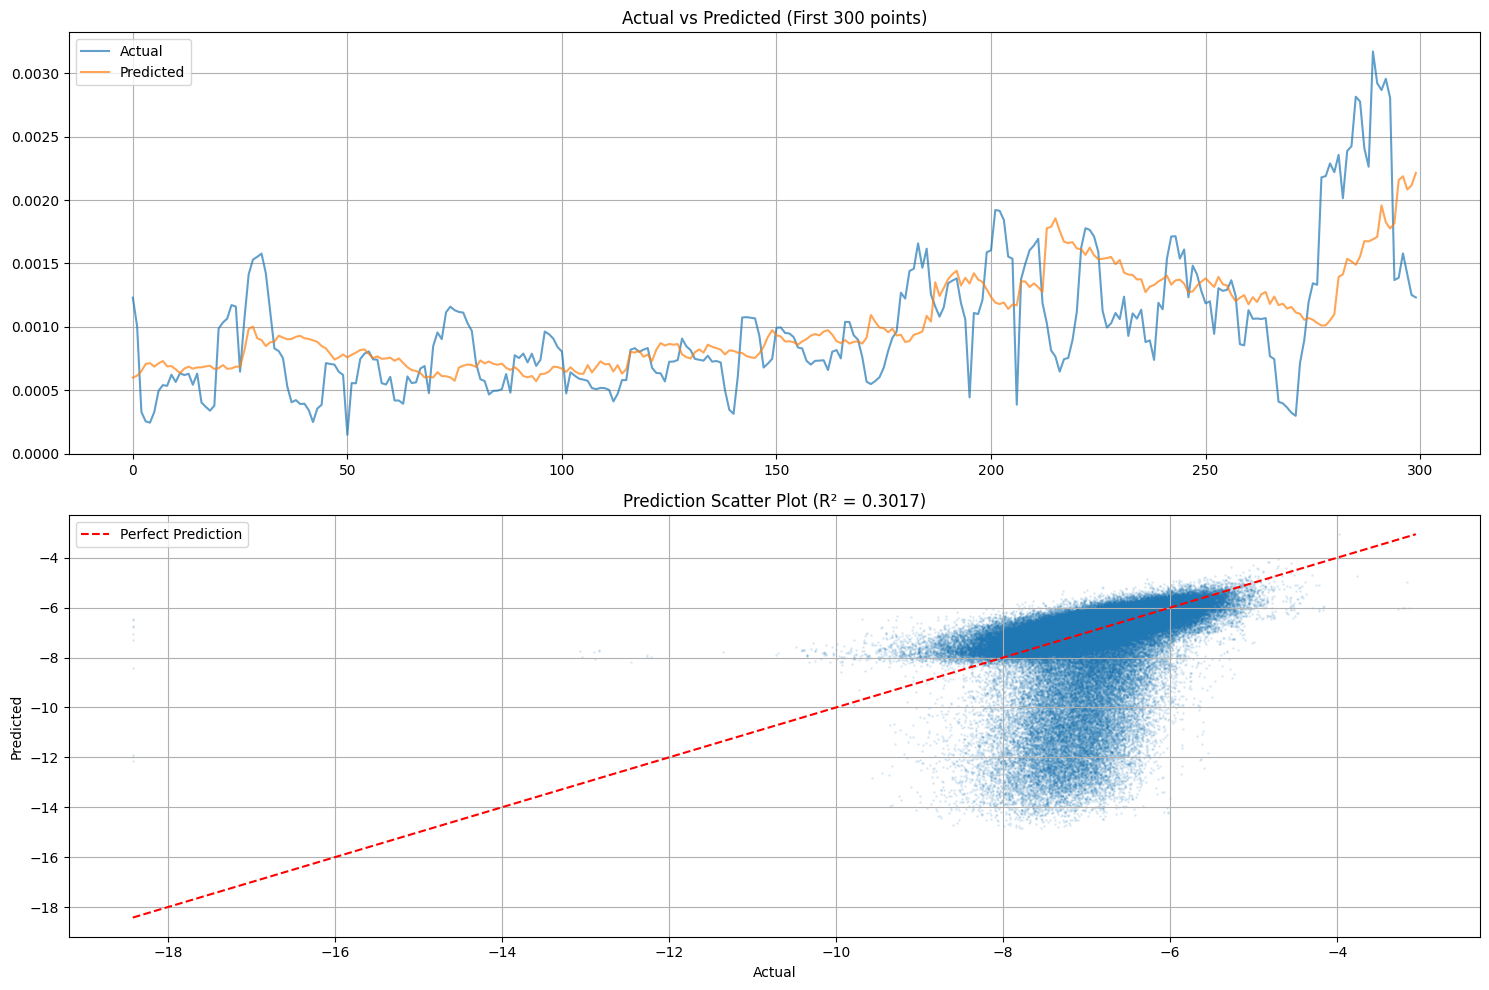

In [33]:
def evaluate_and_visualize(model, test_loader, target_scaler):
    device = torch.device('mps')
    model.load_state_dict(torch.load("best_transformer.pt", weights_only=True))
    model.eval()
    
    preds = []
    trues = []

    with torch.no_grad():
        for Xb, yb in tqdm(test_loader, desc="Testing"):
            Xb = Xb.to(device)
            pred = model(Xb)
            preds.append(pred.cpu().numpy())
            trues.append(yb.numpy())

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    
    # Inverse z-score
    preds_log = target_scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
    trues_log = target_scaler.inverse_transform(trues.reshape(-1, 1)).flatten()

    # 🔥 Inverse log transform
    preds_rv = np.exp(preds_log)
    trues_rv = np.exp(trues_log)

    # Metrics on ORIGINAL scale
    mse = mean_squared_error(trues_rv, preds_rv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues_rv, preds_rv)
    r2 = r2_score(trues_rv, preds_rv)

    print("\n====== 📊 Final Test Performance ======")
    print(f"MSE  : {mse:.8f}")
    print(f"RMSE : {rmse:.8f}")
    print(f"MAE  : {mae:.8f}")
    print(f"R²   : {r2:.4f}")

    # Visualization
    plt.figure(figsize=(15, 10))

    # 1. Line Plot (First 300 points)
    plt.subplot(2, 1, 1)
    limit = 300
    plt.plot(trues_rv[:limit], label='Actual', alpha=0.7)
    plt.plot(preds_rv[:limit], label='Predicted', alpha=0.7)
    plt.title(f'Actual vs Predicted (First {limit} points)')
    plt.legend()
    plt.grid(True)

    # 2. Scatter Plot
    plt.subplot(2, 1, 2)
    plt.scatter(trues_log, preds_log, alpha=0.1, s=1)
    
    # Plot diagonal line
    min_val = min(np.min(trues_log), np.min(preds_log))
    max_val = max(np.max(trues_log), np.max(preds_log))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Prediction Scatter Plot (R² = {r2:.4f})')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return preds_log, trues_log

final_preds, final_trues = evaluate_and_visualize(btc_model, test_loader, target_scaler)

Features: ['l1__ask_up_ret', 'abs_ret_1m', 'l1__tick_count', 'Spread_ma_15m', 'rv_30m_lag5', 'OFI_std_30m', 'tr__bin_id', 'l1__l3_updates', 'l2__ask_30bps_fill_size', 'l2__ask_100bps_fill_size', 'tr__ramp_up', 'L1_Imbalance', 'l2__bid_size', 'VWAP_deviation', 'l2__ask_10bps_fill_size', 'ret_1m', 'l2__bid_1bps_fill_size', 'l2__bid_100bps_fill_size', 'VPIN_proxy', 'log_volume']
Filtering for BTC only...
Split Dates -> Train End: 2024-05-26 16:45:00+00:00 | Val End: 2024-09-13 08:20:00+00:00
Creating sequences... (This might take a moment)


Creating sequences for BTCUSDT:   0%|          | 0/736815 [00:00<?, ?it/s]

Creating sequences for BTCUSDT:   0%|          | 0/157865 [00:00<?, ?it/s]

Creating sequences for BTCUSDT:   0%|          | 0/157865 [00:00<?, ?it/s]

Train samples: 736815 | Val samples: 157865 | Test samples: 157865
Using device: mps


/Users/hwakim/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/5 (train):   0%|          | 0/1440 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.428521 | Val Loss: 0.340153 | LR: 1.00e-03


Epoch 2/5 (train):   0%|          | 0/1440 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.411649 | Val Loss: 0.332653 | LR: 1.00e-03


Epoch 3/5 (train):   0%|          | 0/1440 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.406179 | Val Loss: 0.342840 | LR: 1.00e-03


Epoch 4/5 (train):   0%|          | 0/1440 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.456661 | Val Loss: 0.339836 | LR: 1.00e-03


Epoch 5/5 (train):   0%|          | 0/1440 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.402492 | Val Loss: 0.333038 | LR: 5.00e-04
Training Done.


Testing:   0%|          | 0/309 [00:00<?, ?it/s]


====== 📊 Final Test Performance ======
MSE  : 0.00000044
RMSE : 0.00066627
MAE  : 0.00042868
R²   : 0.4692


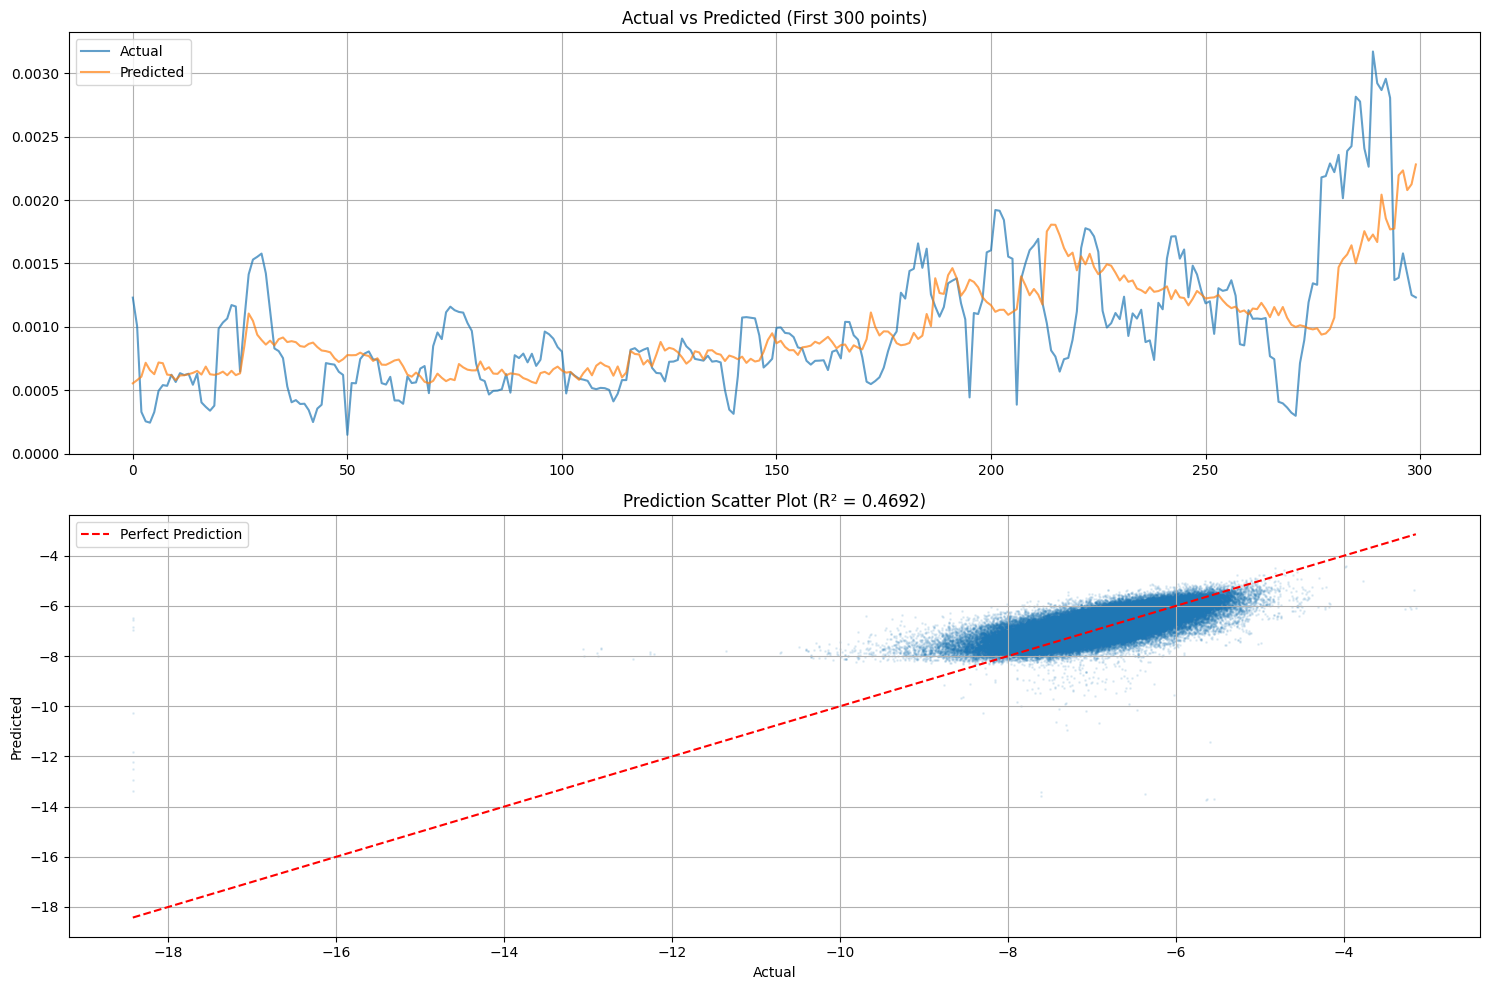

In [64]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

TARGET = "log_rv_fwd_5m"
ORGN_TARGET = 'rv_fwd_5m'
SEQ_LEN = 30
BATCH_SIZE = 512

# 1. 기본 전처리
full_df = full_df.replace([np.inf, -np.inf], 0).fillna(0)

full_df[TARGET] = np.log(full_df[ORGN_TARGET] + 1e-8)

btc_features = ['l1__ask_up_ret', 'abs_ret_1m', 'l1__tick_count', 'Spread_ma_15m', 'rv_30m_lag5', 'OFI_std_30m', 'tr__bin_id', 'l1__l3_updates', 'l2__ask_30bps_fill_size', 'l2__ask_100bps_fill_size', 'tr__ramp_up', 'L1_Imbalance', 'l2__bid_size', 'VWAP_deviation', 'l2__ask_10bps_fill_size', 'ret_1m', 'l2__bid_1bps_fill_size', 'l2__bid_100bps_fill_size', 'VPIN_proxy', 'log_volume']

eth_features = ['l1__ask_up_ret', 'abs_ret_1m', 'l1__tick_count', 'ret_1m', 'VWAP_deviation', 'tr__bin_id', 'rv_30m', 'l2__bid_100bps_fill_size', 'rv_30m_lag5', 'Spread_ma_15m', 'OFI_std_30m', 'l2__ask_30bps_fill_size', 'l2__ask_100bps_fill_size', 'l1__l3_updates', 'OFI_roc_10m', 'l2__ask_10bps_fill_size', 'L1_Imbalance', 'l2__bid_size', 'depth_ratio_10M', 'OFI_raw']
feature_cols = btc_features.copy()
print(f"Features: {feature_cols}")

# 2. BTC Only & Time-Based Split
# 데이터 양이 많아 처리가 힘들 경우, BTC만 먼저 필터링하여 진행합니다.
print("Filtering for BTC only...")
btc_df = full_df[full_df['symbol'] == 'BTCUSDT'].copy()

# 날짜 기준으로 정렬
btc_df = btc_df.sort_values(["dt"]).reset_index(drop=True)
dates = btc_df["dt"].sort_values().unique()

train_end_idx = int(len(dates) * 0.7)
val_end_idx = int(len(dates) * 0.85)

train_date_end = dates[train_end_idx]
val_date_end = dates[val_end_idx]

print(f"Split Dates -> Train End: {train_date_end} | Val End: {val_date_end}")

train_df = btc_df[btc_df["dt"] <= train_date_end].copy()
val_df = btc_df[(btc_df["dt"] > train_date_end) & (btc_df["dt"] <= val_date_end)].copy()
test_df = btc_df[btc_df["dt"] > val_date_end].copy()

# 3. Scaling (StandardScaler) - Train 데이터 기준으로 Fit
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
val_df[feature_cols] = scaler.transform(val_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

# Target도 스케일링 하는 것이 학습 안정성에 좋음 (선택사항이나 추천)
target_scaler = StandardScaler()
train_df[[TARGET]] = target_scaler.fit_transform(train_df[[TARGET]])
val_df[[TARGET]] = target_scaler.transform(val_df[[TARGET]])
test_df[[TARGET]] = target_scaler.transform(test_df[[TARGET]])

# ==========================================
# 2. Dataset & DataLoader (Boundary Safe)
# ==========================================

def create_sequences(df, seq_len, feature_cols, target_col):
    """
    각 심볼별로 시퀀스를 만든 후 합칩니다.
    이렇게 해야 Symbol A의 끝과 Symbol B의 시작이 섞이지 않습니다.
    """
    X_list = []
    y_list = []
    
    # 심볼 그룹별로 처리 (BTC만 선택했으므로 1번만 돌게 됩니다)
    for sym, group in df.groupby("symbol"):
        group = group.sort_values("dt")
        data_x = group[feature_cols].values
        data_y = group[target_col].values
        
        # Sliding Window for this symbol
        # tqdm을 추가하여 시퀀스 생성 진행 상황을 표시합니다.
        # leave=False로 설정하여 완료된 바는 사라지게 할 수 있습니다 (취향에 따라 제거 가능)
        for i in tqdm(range(len(data_x) - seq_len), desc=f"Creating sequences for {sym}"):
            X_list.append(data_x[i : i + seq_len])
            y_list.append(data_y[i + seq_len])
            
    return np.array(X_list, dtype=np.float32), np.array(y_list, dtype=np.float32)

print("Creating sequences... (This might take a moment)")
X_train, y_train = create_sequences(train_df, SEQ_LEN, feature_cols, TARGET)
X_val, y_val     = create_sequences(val_df,   SEQ_LEN, feature_cols, TARGET)
X_test, y_test   = create_sequences(test_df,  SEQ_LEN, feature_cols, TARGET)

class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = NumpyDataset(X_train, y_train)
val_dataset   = NumpyDataset(X_val, y_val)
test_dataset  = NumpyDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")

# ==========================================
# 3. Improved Transformer Model
# ==========================================

class ImprovedTimeSeriesTransformer(nn.Module):
    def __init__(self, n_features, d_model=64, n_heads=4, num_layers=3, dropout=0.1):
        super().__init__()
        
        # 1. Feature Projection
        self.input_proj = nn.Linear(n_features, d_model)
        
        # 2. Positional Encoding (Learnable is fine, but sinusoidal often better for TS)
        self.pos_embedding = nn.Parameter(torch.randn(1, SEQ_LEN, d_model))
        
        # 3. Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True,
            norm_first=True # Pre-Norm usually converges better
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 4. Output Head
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )

    def forward(self, x):
        # x: (batch, seq_len, n_features)
        
        # Embedding
        x = self.input_proj(x)
        x = x + self.pos_embedding[:, :x.size(1), :]
        
        # Encoder
        z = self.encoder(x)
        
        # Pooling Strategy: Use the LAST token's output
        # 금융 시계열에서는 마지막 시점의 정보가 가장 중요함
        last_token_out = z[:, -1, :] 
        
        out = self.head(last_token_out)
        return out.squeeze(-1)

# ==========================================
# 4. Training Loop
# ==========================================

def train_loop(model, train_loader, val_loader, epochs=10, lr=1e-4):
    device = "mps"
    print(f"Using device: {device}")
    model = model.to(device)
    
    # Optimizer & Loss
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_fn = nn.MSELoss()
    
    # Scheduler (Optional but recommended)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=2)

    best_val_loss = float('inf')
    
    for ep in range(epochs):
        model.train()
        train_losses = []
        pbar = tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs} (train)", leave=False)

        for Xb, yb in pbar:
            Xb, yb = Xb.to(device), yb.to(device)

            pred = model(Xb)
            loss = loss_fn(pred, yb)

            opt.zero_grad()
            loss.backward()
            
            # Gradient Clipping (Transformer 학습 안정화)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            opt.step()

            train_losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.6f}"})

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                pred = model(Xb)
                val_losses.append(loss_fn(pred, yb).item())

        avg_train = np.mean(train_losses)
        avg_val = np.mean(val_losses)
        
        # Scheduler Step
        scheduler.step(avg_val)
        
        print(f"Epoch {ep+1} | Train Loss: {avg_train:.6f} | Val Loss: {avg_val:.6f} | LR: {opt.param_groups[0]['lr']:.2e}")

        # Save Best Model
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), "best_transformer.pt")
            
    print("Training Done.")
    return model

# Initialize and Train
model = ImprovedTimeSeriesTransformer(n_features=len(feature_cols))
model = train_loop(model, train_loader, val_loader, epochs=5, lr=1e-3)

# ==========================================
# 5. Evaluation & Visualization
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_and_visualize(model, test_loader, target_scaler):
    device = "mps"
    model.load_state_dict(torch.load("best_transformer.pt", weights_only=True))
    model.eval()
    
    preds = []
    trues = []

    with torch.no_grad():
        for Xb, yb in tqdm(test_loader, desc="Testing"):
            Xb = Xb.to(device)
            pred = model(Xb)
            preds.append(pred.cpu().numpy())
            trues.append(yb.numpy())

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    
    # Inverse z-score
    preds_log = target_scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
    trues_log = target_scaler.inverse_transform(trues.reshape(-1, 1)).flatten()

    # 🔥 Inverse log transform
    preds_rv = np.exp(preds_log)
    trues_rv = np.exp(trues_log)

    # Metrics on ORIGINAL scale
    mse = mean_squared_error(trues_rv, preds_rv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues_rv, preds_rv)
    r2 = r2_score(trues_rv, preds_rv)

    print("\n====== 📊 Final Test Performance ======")
    print(f"MSE  : {mse:.8f}")
    print(f"RMSE : {rmse:.8f}")
    print(f"MAE  : {mae:.8f}")
    print(f"R²   : {r2:.4f}")

    # Visualization
    plt.figure(figsize=(15, 10))

    # 1. Line Plot (First 300 points)
    plt.subplot(2, 1, 1)
    limit = 300
    plt.plot(trues_rv[:limit], label='Actual', alpha=0.7)
    plt.plot(preds_rv[:limit], label='Predicted', alpha=0.7)
    plt.title(f'Actual vs Predicted (First {limit} points)')
    plt.legend()
    plt.grid(True)

    # 2. Scatter Plot
    plt.subplot(2, 1, 2)
    plt.scatter(trues_log, preds_log, alpha=0.1, s=1)
    
    # Plot diagonal line
    min_val = min(np.min(trues_log), np.min(preds_log))
    max_val = max(np.max(trues_log), np.max(preds_log))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Prediction Scatter Plot (R² = {r2:.4f})')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return preds_log, trues_log

final_preds, final_trues = evaluate_and_visualize(model, test_loader, target_scaler)

In [39]:
def permute_last_k_steps(X, feature_idx, k=5):
    """
    마지막 k timestep만 permutation (Transformer-friendly)
    X: (B, T, F)
    """
    Xp = X.clone()
    perm_idx = torch.randperm(Xp.size(0))
    Xp[:, -k:, feature_idx] = Xp[perm_idx, -k:, feature_idx]
    return Xp

Analysis running on: mps
>>> 1. Calculating Global Feature Importance...
Baseline MSE: 0.327379


  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/s3/33g1ppqs5_70glkm7hspvkwc0000gn/T/ipykernel_80459/1242580711.py:178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')


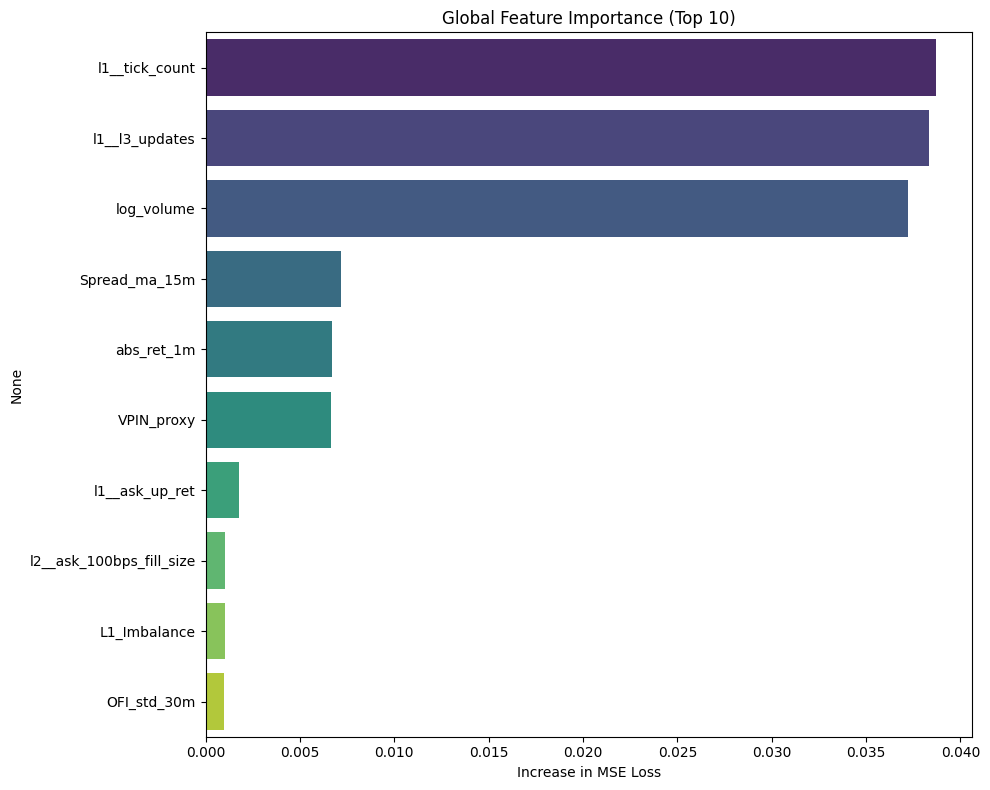


>>> 2. Analyzing Feature Stability across Regimes...
High Vol Samples: 31573
Low Vol Samples: 78933

Analyzing High Volatility Regime...


High Volatility Importance:   0%|          | 0/20 [00:00<?, ?it/s]


Analyzing Low Volatility Regime...


Low Volatility Importance:   0%|          | 0/20 [00:00<?, ?it/s]

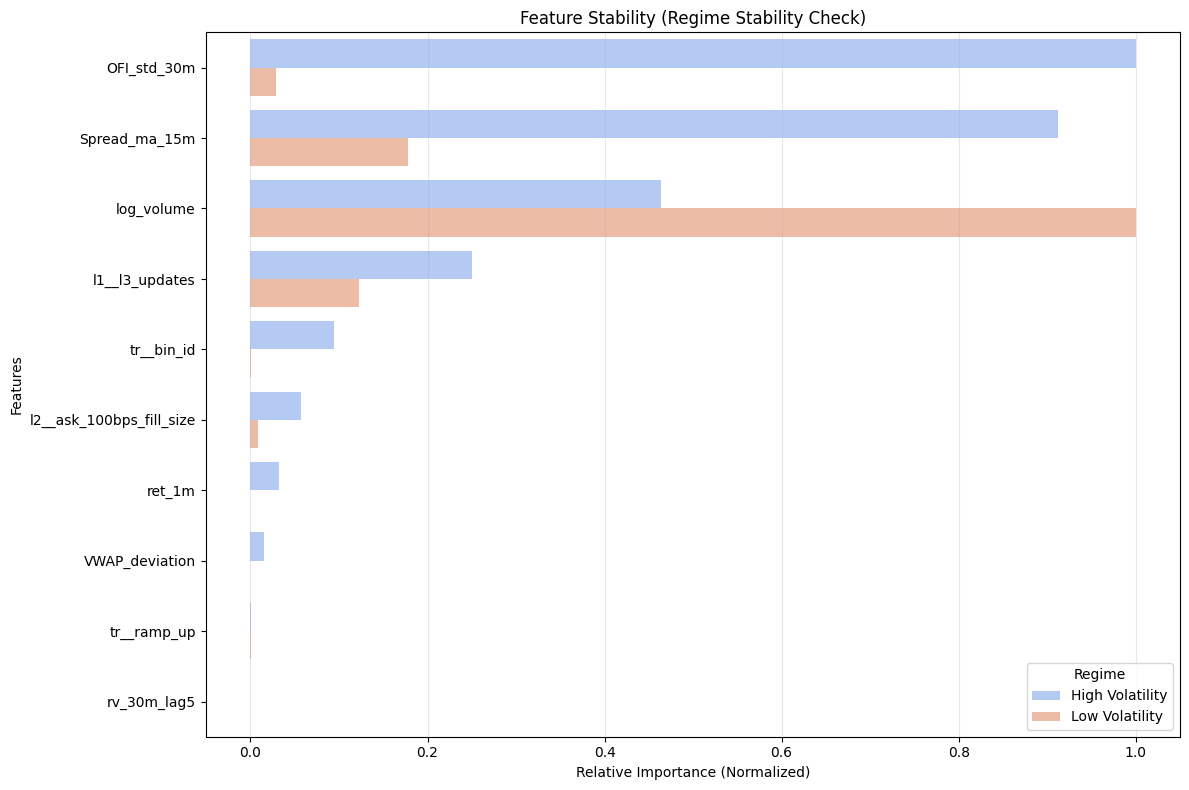


=== Top 5 Important Features (Global) ===
l1__tick_count    0.038700
l1__l3_updates    0.038327
log_volume        0.037244
Spread_ma_15m     0.007179
abs_ret_1m        0.006675
dtype: float64

=== Top 5 Important Features in High Volatility (Crash) Regime ===
                High Volatility  Low Volatility
OFI_std_30m            0.057927        0.013385
Spread_ma_15m          0.052829        0.083792
log_volume             0.026886        0.470152
l1__l3_updates         0.014505        0.057852
tr__bin_id             0.005469        0.000478


In [65]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import copy

# ==========================================
# 0. Device Setup (Auto-Detect)
# ==========================================
def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available(): # For Mac M1/M2/M3
        return 'mps'
    else:
        return 'cpu'

DEVICE = get_device()
print(f"Analysis running on: {DEVICE}")

# ==========================================
# 1. Permutation Feature Importance (Global)
# ==========================================

def calculate_permutation_importance(
    model,
    data_loader,
    feature_cols,
    device=DEVICE,
    k=5,
    n_perm=5
):
    model.eval()
    model.to(device)
    criterion = nn.MSELoss()

    X_all, y_all, preds_all = [], [], []

    print("Collecting data...")
    with torch.no_grad():
        for Xb, yb in data_loader:
            X_all.append(Xb)
            y_all.append(yb)
            preds_all.append(model(Xb.to(device)).cpu())

    X_all = torch.cat(X_all).cpu()
    y_all = torch.cat(y_all).cpu()
    preds_all = torch.cat(preds_all)

    baseline_loss = criterion(preds_all, y_all).item()
    print(f"Baseline MSE: {baseline_loss:.6f}")

    importances = {}
    dataset_size = X_all.size(0)
    eval_batch_size = 256 if device != "cpu" else 1024

    for i, col in enumerate(tqdm(feature_cols)):
        perm_losses = []

        for _ in range(n_perm):
            Xp = permute_last_k_steps(X_all, i, k=k)

            perm_preds = []
            with torch.no_grad():
                for s in range(0, dataset_size, eval_batch_size):
                    e = min(s + eval_batch_size, dataset_size)
                    perm_preds.append(model(Xp[s:e].to(device)).cpu())

            perm_loss = criterion(torch.cat(perm_preds), y_all).item()
            perm_losses.append(perm_loss)

        importances[col] = np.mean(perm_losses) - baseline_loss

    imp = pd.Series(importances).sort_values(ascending=False)
    imp = imp.clip(lower=0)
    imp = imp.clip(upper=imp.quantile(0.99))

    return imp

# ==========================================
# 2. Regime-based Feature Stability Analysis
# ==========================================

def analyze_regime_importance(model, data_loader, feature_cols, target_scaler, device=DEVICE):
    """
    Feature Stability Analysis:
    Seperate two regimes: Low-Vol and High-vol
    and compare which feature is important in each period.
    """
    model.eval()
    model.to(device)
    criterion = nn.MSELoss()
    
    # 1. Data Load and Predict
    X_all = []
    y_all = []
    preds_all = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_all.append(X_batch)
            y_all.append(y_batch)
            X_batch = X_batch.to(device)
            preds_all.append(model(X_batch).cpu())
            
    X_all = torch.cat(X_all).cpu()
    y_all = torch.cat(y_all).cpu()
    
    # 2. Seperate Regime (Target Value: High - above 20% vs Low - below 50%)
    threshold_high = torch.quantile(y_all, 0.80)
    threshold_low = torch.quantile(y_all, 0.50)
    
    high_vol_mask = y_all >= threshold_high
    low_vol_mask = y_all <= threshold_low
    
    print(f"High Vol Samples: {high_vol_mask.sum().item()}")
    print(f"Low Vol Samples: {low_vol_mask.sum().item()}")
    
    regimes = {
        'High Volatility': (X_all[high_vol_mask], y_all[high_vol_mask]),
        'Low Volatility': (X_all[low_vol_mask], y_all[low_vol_mask])
    }
    
    regime_importances = {}
    eval_batch_size = 512 if device != 'cpu' else 1024

    for regime_name, (X_regime, y_regime) in regimes.items():
        print(f"\nAnalyzing {regime_name} Regime...")
        
        # Baseline Loss for this regime
        dataset_size = X_regime.size(0)
        base_preds = []
        
        with torch.no_grad():
             for start_idx in range(0, dataset_size, eval_batch_size):
                end_idx = min(start_idx + eval_batch_size, dataset_size)
                batch_X = X_regime[start_idx:end_idx].to(device)
                base_preds.append(model(batch_X).cpu())
        
        base_loss = criterion(torch.cat(base_preds), y_regime).item()
        
        importances = {}
        
        # Calculate Permutation Importance for this regime
        for i, col_name in enumerate(tqdm(feature_cols, desc=f"{regime_name} Importance", leave=False)):
            X_permuted = X_regime.clone()
            perm_idx = torch.randperm(X_permuted.size(0))
            X_permuted[:, :, i] = X_permuted[perm_idx, :, i]
            
            perm_preds = []
            with torch.no_grad():
                for start_idx in range(0, dataset_size, eval_batch_size):
                    end_idx = min(start_idx + eval_batch_size, dataset_size)
                    batch_X = X_permuted[start_idx:end_idx].to(device)
                    perm_preds.append(model(batch_X).cpu())
            
            perm_loss = criterion(torch.cat(perm_preds), y_regime).item()
            importances[col_name] = perm_loss - base_loss
            
        regime_importances[regime_name] = importances
        
    return pd.DataFrame(regime_importances)


# ==========================================
# 3. Visualization Helper
# ==========================================

def plot_importance_analysis(importance_df, title="Feature Importance Analysis"):
    # 1. 전체 중요도 시각화 (Series)
    if isinstance(importance_df, pd.Series):
        plt.figure(figsize=(10, 8))
        # 상위 20개만 시각화
        top_n = importance_df.head(10)
        sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')
        plt.title(f"{title} (Top 10)")
        plt.xlabel("Increase in MSE Loss")
        plt.tight_layout()
        plt.show()
        
    # 2. Regime Comparison
    elif isinstance(importance_df, pd.DataFrame):
        # (MinMax Scaling)
        normalized_df = importance_df.copy()
        for col in normalized_df.columns:
            if normalized_df[col].max() != 0:
                normalized_df[col] = normalized_df[col] / normalized_df[col].max()
            
        # High Volatility - Top 15
        top_features = normalized_df.sort_values('High Volatility', ascending=False).head(10).index
        plot_data = normalized_df.loc[top_features].reset_index().melt(id_vars='index')
        
        plt.figure(figsize=(12, 8))
        sns.barplot(data=plot_data, y='index', x='value', hue='variable', palette='coolwarm')
        plt.title(f"{title} (Regime Stability Check)")
        plt.xlabel("Relative Importance (Normalized)")
        plt.ylabel("Features")
        plt.grid(axis='x', alpha=0.3)
        plt.legend(title="Regime")
        plt.tight_layout()
        plt.show()

# ==========================================
# Execution Block
# ==========================================

# 1. Global Feature Importance
print(">>> 1. Calculating Global Feature Importance...")
global_imp = calculate_permutation_importance(model, test_loader, feature_cols, device=DEVICE)
plot_importance_analysis(global_imp, title="Global Feature Importance")

# 2. Regime Stability Analysis
print("\n>>> 2. Analyzing Feature Stability across Regimes...")
regime_imp_df = analyze_regime_importance(model, test_loader, feature_cols, target_scaler, device=DEVICE)
plot_importance_analysis(regime_imp_df, title="Feature Stability")

print("\n=== Top 5 Important Features (Global) ===")
print(global_imp.head(5))

print("\n=== Top 5 Important Features in High Volatility (Crash) Regime ===")
print(regime_imp_df.sort_values('High Volatility', ascending=False).head(5))


/var/folders/s3/33g1ppqs5_70glkm7hspvkwc0000gn/T/ipykernel_80459/1324126396.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')


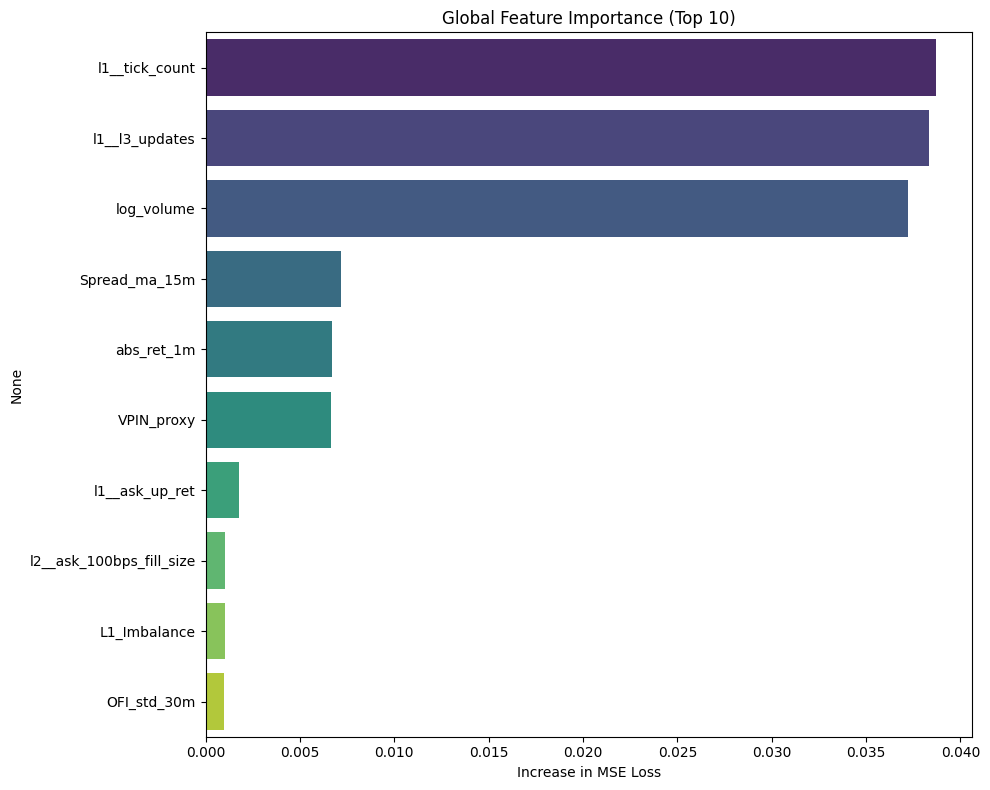

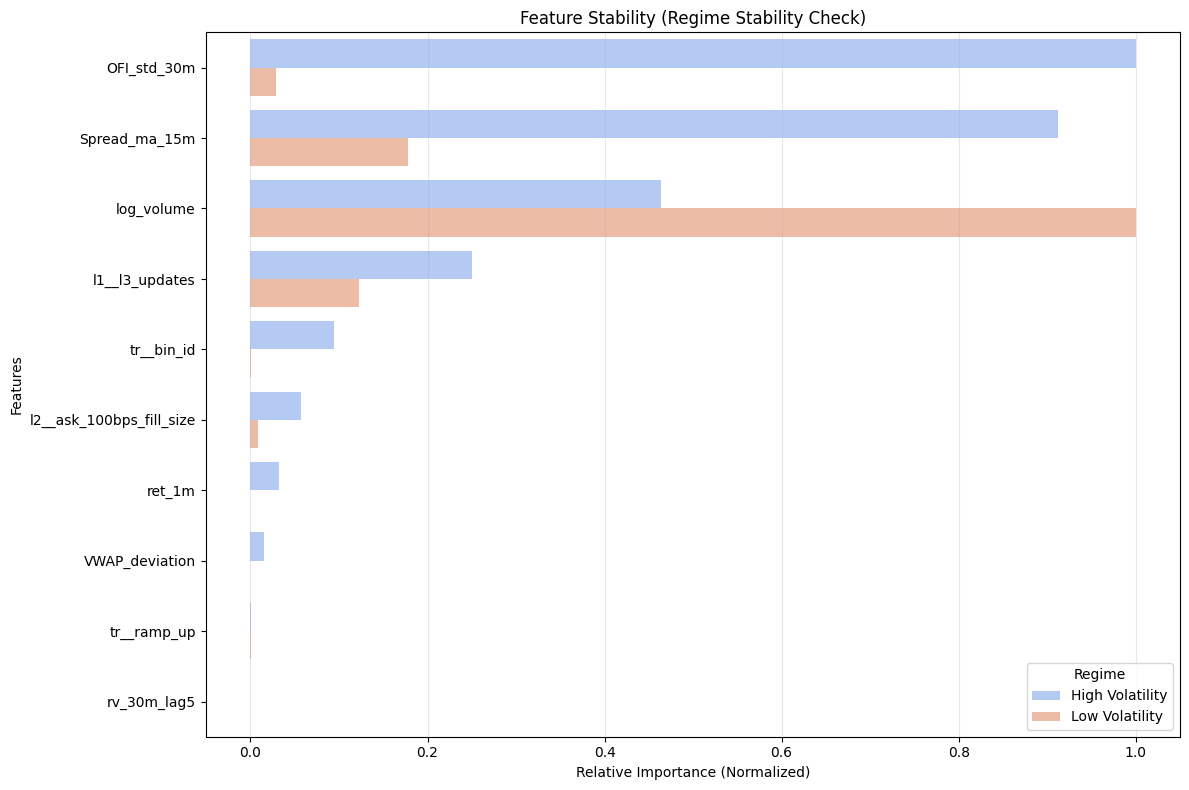

In [66]:
# ==========================================
# 3. Visualization Helper
# ==========================================

def plot_importance_analysis(importance_df, title="Feature Importance Analysis"):
    # 1. 전체 중요도 시각화 (Series)
    if isinstance(importance_df, pd.Series):
        plt.figure(figsize=(10, 8))
        # 상위 20개만 시각화
        top_n = importance_df.head(10)
        sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')
        plt.title(f"{title} (Top 10)")
        plt.xlabel("Increase in MSE Loss")
        plt.tight_layout()
        plt.show()
        
    # 2. Regime별 비교 시각화 (DataFrame)
    elif isinstance(importance_df, pd.DataFrame):
        # 정규화 (MinMax Scaling)
        normalized_df = importance_df.copy()
        for col in normalized_df.columns:
            if normalized_df[col].max() != 0:
                normalized_df[col] = normalized_df[col] / normalized_df[col].max()
            
        # High Volatility 기준 상위 15개
        top_features = normalized_df.sort_values('High Volatility', ascending=False).head(10).index
        plot_data = normalized_df.loc[top_features].reset_index().melt(id_vars='index')
        
        plt.figure(figsize=(12, 8))
        sns.barplot(data=plot_data, y='index', x='value', hue='variable', palette='coolwarm')
        plt.title(f"{title} (Regime Stability Check)")
        plt.xlabel("Relative Importance (Normalized)")
        plt.ylabel("Features")
        plt.grid(axis='x', alpha=0.3)
        plt.legend(title="Regime")
        plt.tight_layout()
        plt.show()
        
plot_importance_analysis(global_imp, title="Global Feature Importance")
plot_importance_analysis(regime_imp_df, title="Feature Stability")

Baseline MSE: 0.327379
TradeIntensity    0.092412
Volume            0.036141
OrderFlow         0.012190
Liquidity         0.010344
Returns           0.006551
Volatility       -0.000003
dtype: float64


/var/folders/s3/33g1ppqs5_70glkm7hspvkwc0000gn/T/ipykernel_80459/1653082117.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_imp.values, y=group_imp.index, palette="magma")


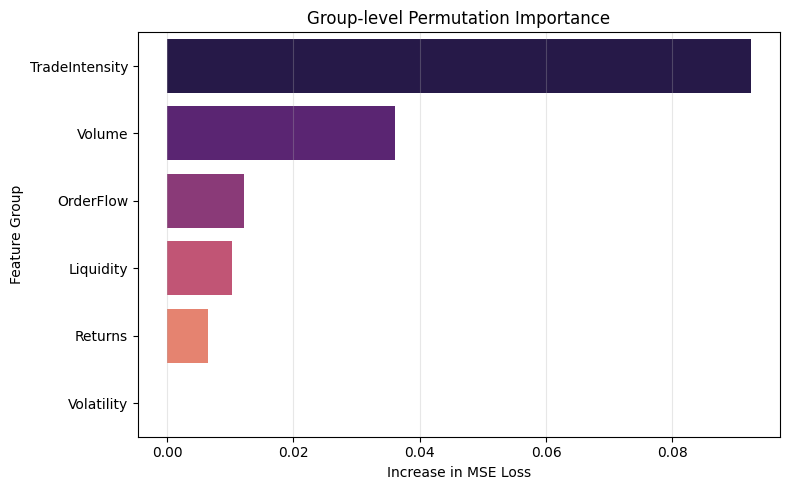

In [67]:
FEATURE_GROUPS = {
    "OrderFlow": [
        "OFI_raw",
        "OFI_std_30m",
        "OFI_roc_10m",
        "Liquidity_Weighted_OFI",
        "VPIN_proxy",
    ],

    "Liquidity": [
        "L1_Imbalance",
        "Mean_Spread",
        "Spread_ma_15m",
        "VWAP_deviation",
        "depth_ratio_10M",
        "l2__bid_size",
        "l2__ask_10bps_fill_size",
        "l2__ask_30bps_fill_size",
        "l2__ask_100bps_fill_size",
        "l2__bid_100bps_fill_size",
    ],

    "TradeIntensity": [
        "l1__tick_count",
        "l1__l3_updates",
        "Trade_Intensity",
        "tr__bin_id",
        "tr__trade_volatility",
    ],

    "Returns": [
        "ret_1m",
        "abs_ret_1m",
    ],

    "Volatility": [
        "rv_30m",
        "rv_30m_lag5",
    ],

    "Volume": [
        "log_volume",
        "tr__volume",
    ],
}

def permute_feature_group(X, feature_indices, k=5):
    """
    특정 feature group을 마지막 k timestep에서만 permutation
    """
    Xp = X.clone()
    perm_idx = torch.randperm(Xp.size(0))
    
    for idx in feature_indices:
        Xp[:, -k:, idx] = Xp[perm_idx, -k:, idx]
        
    return Xp

def calculate_group_permutation_importance(
    model,
    data_loader,
    feature_cols,
    feature_groups,
    device=DEVICE,
    k=5,
    n_perm=5
):
    model.eval()
    model.to(device)
    criterion = nn.MSELoss()

    # 1. Load full dataset
    X_all, y_all, preds_all = [], [], []

    with torch.no_grad():
        for Xb, yb in data_loader:
            X_all.append(Xb)
            y_all.append(yb)
            preds_all.append(model(Xb.to(device)).cpu())

    X_all = torch.cat(X_all).cpu()
    y_all = torch.cat(y_all).cpu()
    preds_all = torch.cat(preds_all)

    baseline_loss = criterion(preds_all, y_all).item()
    print(f"Baseline MSE: {baseline_loss:.6f}")

    dataset_size = X_all.size(0)
    eval_batch_size = 512 if device != "cpu" else 1024

    group_importance = {}

    for group_name, features in feature_groups.items():
        # 실제 존재하는 feature만
        valid_features = [f for f in features if f in feature_cols]
        if len(valid_features) == 0:
            continue

        feature_indices = [feature_cols.index(f) for f in valid_features]

        perm_losses = []

        for _ in range(n_perm):
            Xp = permute_feature_group(X_all, feature_indices, k=k)

            perm_preds = []
            with torch.no_grad():
                for s in range(0, dataset_size, eval_batch_size):
                    e = min(s + eval_batch_size, dataset_size)
                    perm_preds.append(model(Xp[s:e].to(device)).cpu())

            perm_loss = criterion(torch.cat(perm_preds), y_all).item()
            perm_losses.append(perm_loss)

        group_importance[group_name] = np.mean(perm_losses) - baseline_loss

    return pd.Series(group_importance).sort_values(ascending=False)

group_imp = calculate_group_permutation_importance(
    model,
    test_loader,
    feature_cols,
    FEATURE_GROUPS,
    device=DEVICE,
    k=5,
    n_perm=5
)

print(group_imp)

plt.figure(figsize=(8, 5))
sns.barplot(x=group_imp.values, y=group_imp.index, palette="magma")
plt.title("Group-level Permutation Importance")
plt.xlabel("Increase in MSE Loss")
plt.ylabel("Feature Group")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()